# Preprocessing and registration
This notebook does basic preprocessing and registration for lightsheet data

Note v2 uses my saved data that was downsampled from imaris

version 3a contains downsampled data from imaris with origin and pixel set with metadata. It also has a fix where sampling was done on padded coordinates rather than unpadded

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from glob import glob
from os.path import join as pathjoin
import time

import sys
sys.path.append('..')
import imp
import donglab_workflows as dw
imp.reload(dw)


<module 'donglab_workflows' from '../donglab_workflows.py'>

In [2]:
# for now add emlddmm library for registration
import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
imp.reload(emlddmm)

<module 'emlddmm' from '/home/dtward/data/csh_data/emlddmm/emlddmm.py'>

In [ ]:
# TODO: collect all input arguments in this cell
target_name = 'SW220510_02_LS_6x_1000z_ch_0_pow_[0.125]_down.npz'
# where should outputs go?
output_prefix = 'lightsheet_outputs_2022_09_21/'
# load atlas images
atlas_names = [
    '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_50.vtk',
    '/home/dtward/data/AllenInstitute/allen_vtk/average_template_50.vtk',
]
seg_name = '/home/dtward/data/AllenInstitute/allen_vtk/annotation_50.vtk'
savename = 'transformation_outputs_lightsheet_v03newdownsample.npy'
device = 'cuda:0' # for pytorch

In [4]:
output_directory = os.path.split(output_prefix)[0]
if output_directory:
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

In [5]:
# load target image

In [6]:
target_data = np.load(target_name,allow_pickle=True)

In [7]:
J = target_data['I'][None]
J = J.astype(np.float32)
J /= np.mean(np.abs(J))
xJ = target_data['xI']
dJ = [x[1] - x[0] for x in xJ]
J0 = np.copy(J)
if 'w' in target_data:
    W = target_data['w']
elif 'W' in target_data:
    W = target_data['W']
else:
    W = np.ones_like(J[0])
    # or actually
    W = (J[0]>0).astype(float)
W = (J[0]>0).astype(float)
    

In [8]:
emlddmm.draw(W[None])

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7f438142e810>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f4307210e90>]])

In [9]:
fig,ax = emlddmm.draw(J,xJ,vmin=np.min(J[W[None]>0.9]))
fig.suptitle('Downsampled lightsheet data')
figopts = {'dpi':300,'quality':90}
fig.savefig(output_prefix + 'downsampled.jpg',**figopts)
fig.canvas.draw()

<IPython.core.display.Javascript object>

4294967296 4294967296


In [11]:
I = []
for atlas_name in atlas_names:
    xI,I_,title,names = emlddmm.read_data(atlas_name)
    I_ = I_.astype(np.float32)
    I_ /= np.mean(np.abs(I_))
    I.append(I_)
    
I = np.concatenate(I)    
dI = [x[1] - x[0] for x in xI]
XI = np.meshgrid(*xI,indexing='ij')

xI0 = [ np.copy(x)for x in xI]
I0 = np.copy(I)

<IPython.core.display.Javascript object>


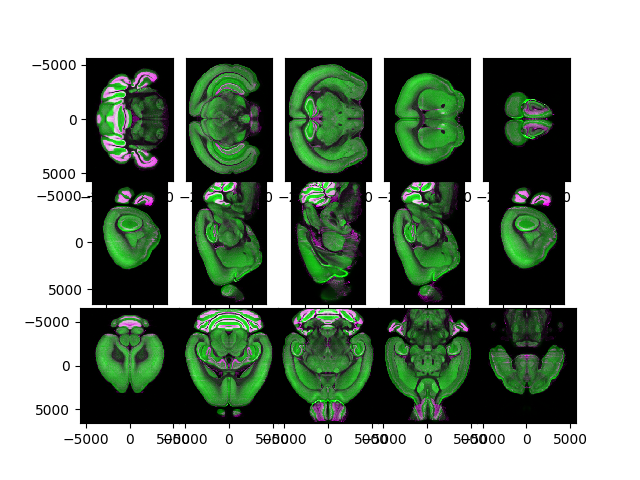

In [12]:
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

In [13]:
# next is to transforom the high resolution data
xS,S,title,names = emlddmm.read_data(seg_name)
# we want to visuze the above with S
labels,inds = np.unique(S,return_inverse=True)

colors = np.random.rand(len(labels),3)
colors[0] = 0.0

RGB = colors[inds].reshape(S.shape[1],S.shape[2],S.shape[3],3).transpose(-1,0,1,2)
#RGB = np.zeros((3,S.shape[1],S.shape[2],S.shape[3]))

#for i,l in enumerate(labels):
#    RGB[:,S[0]==l] = colors[i][...,None]
fig,ax = emlddmm.draw(RGB)
plt.subplots_adjust(wspace=0,hspace=0,right=1)
fig.canvas.draw()

<IPython.core.display.Javascript object>

# Initial preprocessing



## Target preprocessing

<IPython.core.display.Javascript object>


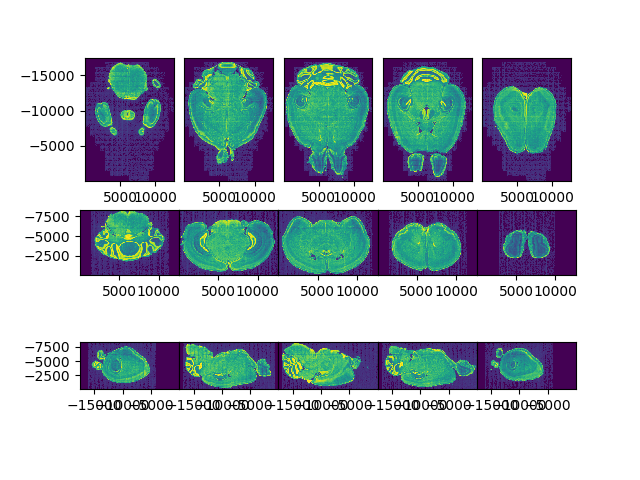

4294967296 4294967296


<IPython.core.display.Javascript object>


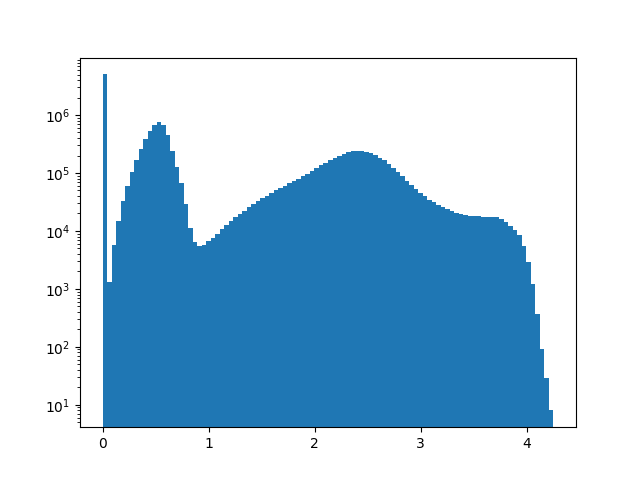

In [15]:
# background
J = J0 - np.quantile(J0[W[None]>0.9],0.1)
J[J<0] = 0
# adjust dynamic range
J = J**0.25

# adjust mean value
J /= np.mean(np.abs(J))
fig,ax = emlddmm.draw(J,xJ,vmin=0)
fig.canvas.draw()
fig.suptitle('Preprocessed lightsheet data')
fig.savefig(output_prefix + 'processed.jpg',**figopts)


fig,ax = plt.subplots()
ax.hist(J.ravel(),100,log=True)
fig.canvas.draw()

## Atlas preprocessing


In [16]:
# pad
# since I will downsample by 4, I want to pad with 4x4x4
npad = 4
I = np.pad(I0,  ((0,0),(npad,npad),(npad,npad),(npad,npad)) )
for i in range(npad):
    xI = [ np.concatenate(   (x[0][None]-d,x,x[-1][None]+d)   ) for d,x in zip(dI,xI0)]


In [17]:
# adjust nissl image dynamic range
I[0] = I[0]**0.5
I[0] /= np.mean(np.abs(I[0]))
I[1] /= np.mean(np.abs(I[1]))

<IPython.core.display.Javascript object>


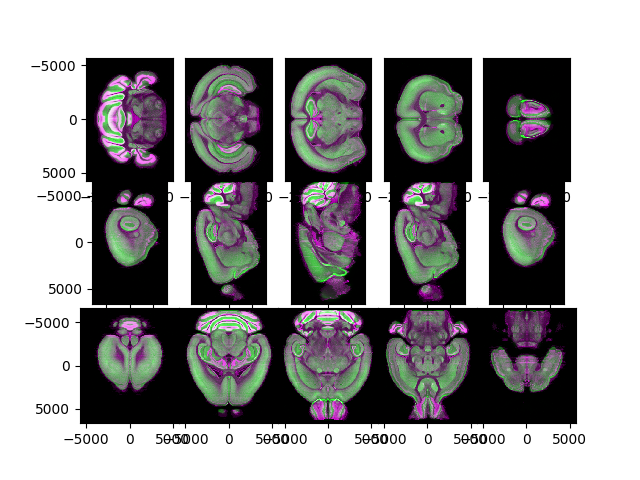

In [18]:
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

# Registration

/home/dtward/data/csh_data/emlddmm/emlddmm.py:2634: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  X = torch.as_tensor(X,dtype=self.data.dtype,device=self.data.device)


<IPython.core.display.Javascript object>


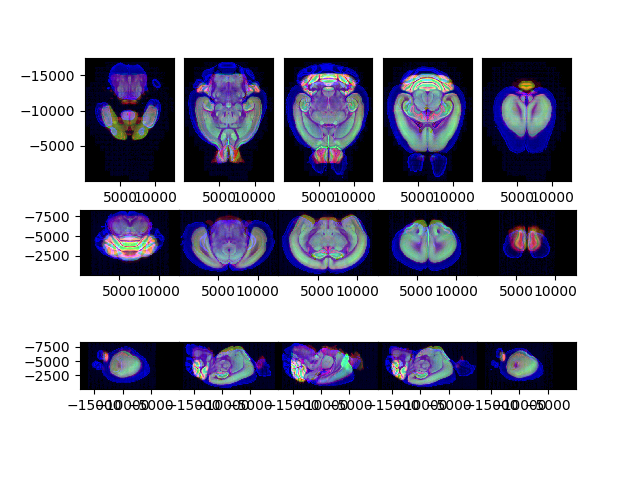

In [19]:
# initial affine
A0 = np.eye(4)
# make sure to keep sign of Jacobian
#A0 = np.diag((1.3,1.3,1.3,1.0))@A0
# flip x0,x1
A0 = np.array([[0.0,-1.0,0.0,0.0],[1.0,0.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip x0,x2
A0 = np.array([[0.0,0.0,-1.0,0.0],[0.0,1.0,0.0,0.0],[1.0,0.0,0.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip x1,x2
#A0 = np.array([[-1.0,0.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,1.0,0.0,0.0],[0.0,0.0,0.0,1.0]])@A0
# flip 
#A0 = np.diag((1.0,-1.0,-1.0,1.0))@A0
# shift
#A0[0,-1] = +3500 # left right, positive will cut off the missing hemisphere as appropriate
#A0[1,-1] = -2500 # AP, negative will cut off the nose
#A0[2,-1] = -1000 # SI, negative will move the venttral surface toward the boundary

XJ = np.meshgrid(*xJ,indexing='ij')
A0[:3,-1] = np.mean(XJ,axis=(-1,-2,-3))

# check it
tform = emlddmm.Transform(A0,direction='b')
AI = emlddmm.apply_transform_float(xI,I,tform.apply(XJ))
fig,ax = emlddmm.draw(np.concatenate((AI[:2],J)),xJ,vmin=0)
fig.canvas.draw()


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


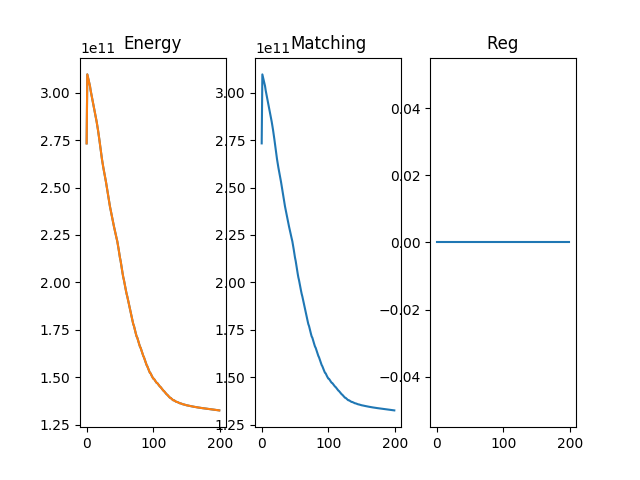

<IPython.core.display.Javascript object>


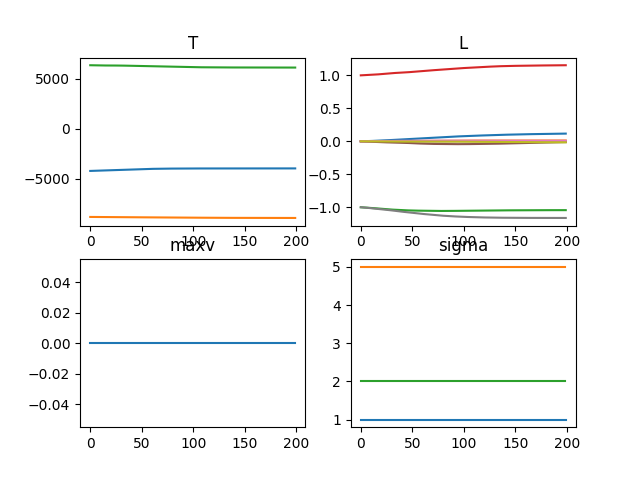

<IPython.core.display.Javascript object>


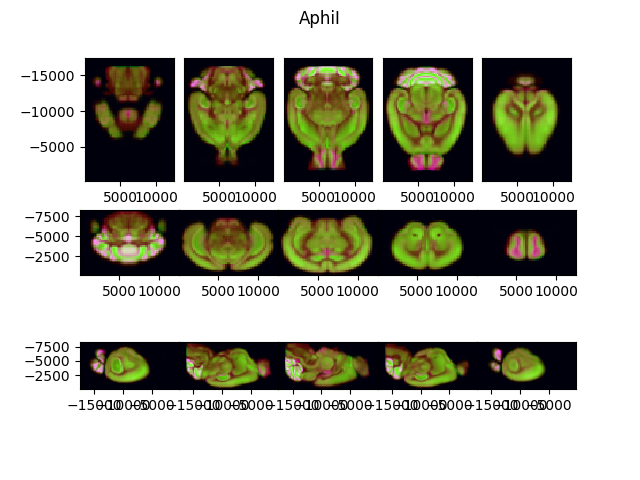

<IPython.core.display.Javascript object>


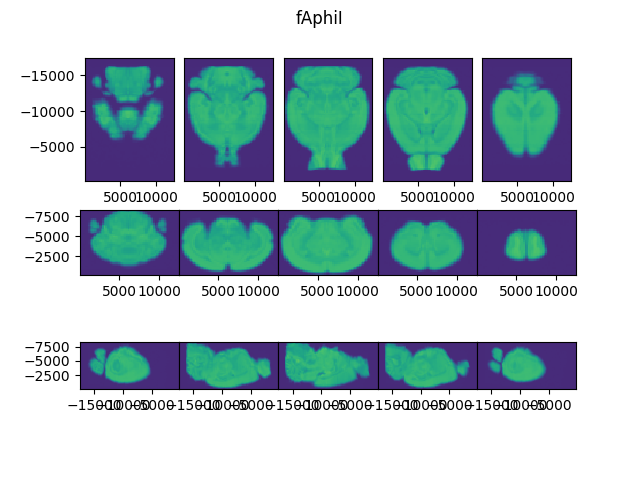

<IPython.core.display.Javascript object>


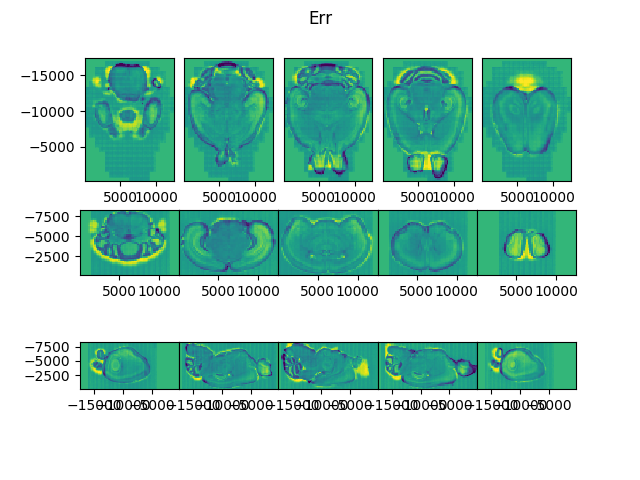

<IPython.core.display.Javascript object>


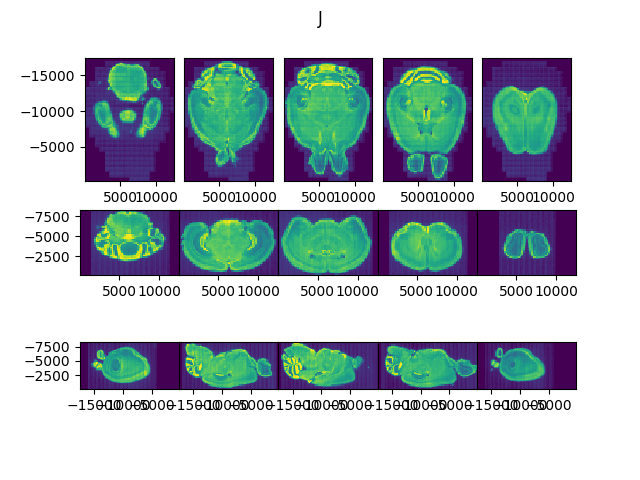

<IPython.core.display.Javascript object>


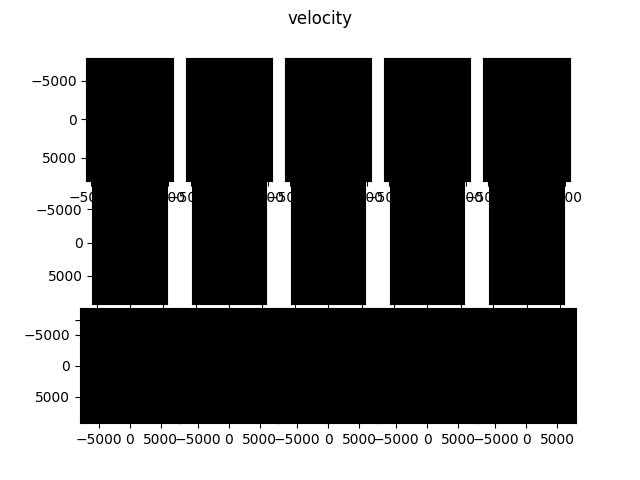

<IPython.core.display.Javascript object>


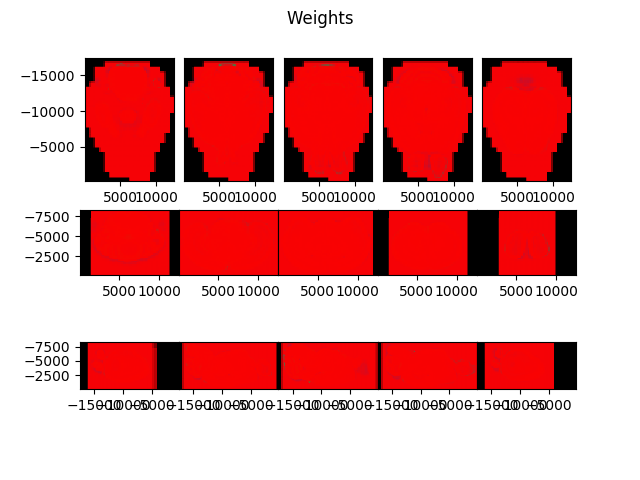

[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
/home/dtward/data/csh_data/emlddmm/emlddmm.py:98: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


In [20]:
# now we want to register
config0 = {
    'device':device,
    'n_iter':200, 'downI':[4,4,4], 'downJ':[4,4,4],
     'priors':[0.9,0.05,0.05],'update_priors':False,
     'update_muA':0,'muA':[np.quantile(J,0.99)],
     'update_muB':0,'muB':[0.0],
     'update_sigmaM':0,'update_sigmaA':0,'update_sigmaB':0,
     'sigmaM':0.25,'sigmaB':0.5,'sigmaA':1.25,
     'order':1,'n_draw':50,'n_estep':3,'slice_matching':0,'v_start':1000,
     'eA':5e4,'A':A0,'full_outputs':True,
   }
# update my sigmas (august 22)
config0['sigmaM'] = 1.0
config0['sigmaB'] = 2.0
config0['sigmaA'] = 5.0
#W = np.ones_like(J[0])
#W = 1.0 - (J[0]==0)
#I_ = np.stack((I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2,))
#I_ = np.stack((I[2],I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2))
#I_ = np.stack((I[0],I[1],I[0]*I[1],I[0]**2,I[1]**2)) # I don't need I[2]
I_ = np.stack((I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
               (I[0]-np.mean(I[0]))**2,
               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
               (I[1]-np.mean(I[0]))**2,))

out = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config0)

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1001: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A,device=device,dtype=dtype).detach().clone()


<IPython.core.display.Javascript object>


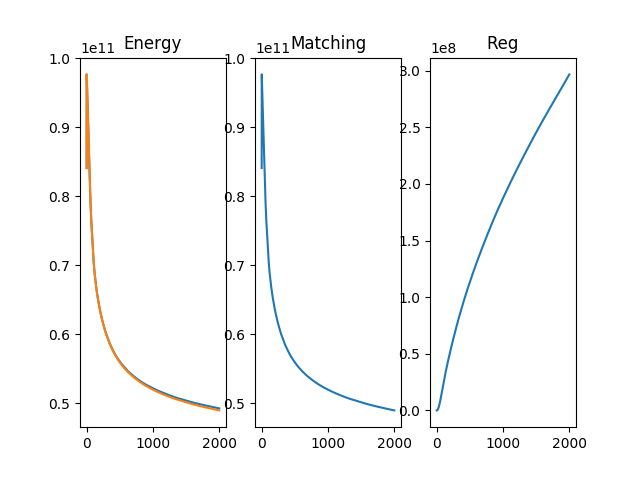

<IPython.core.display.Javascript object>


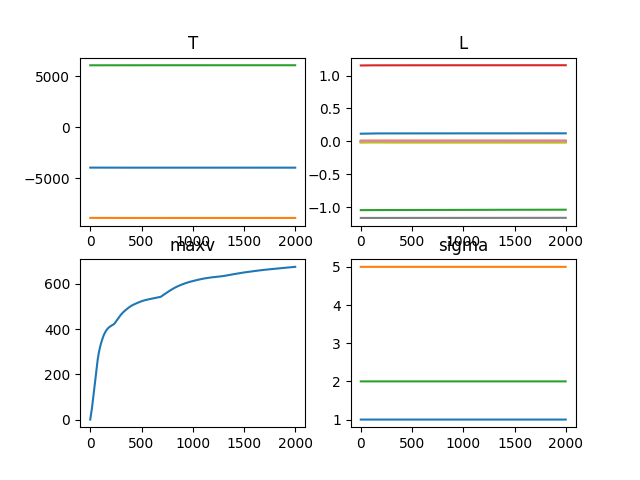

<IPython.core.display.Javascript object>


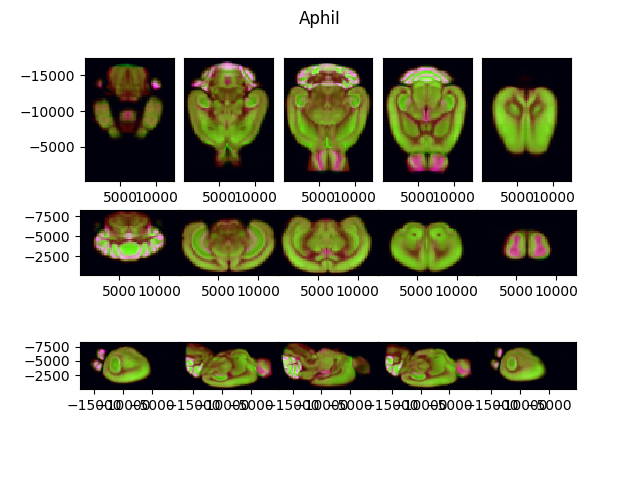

<IPython.core.display.Javascript object>


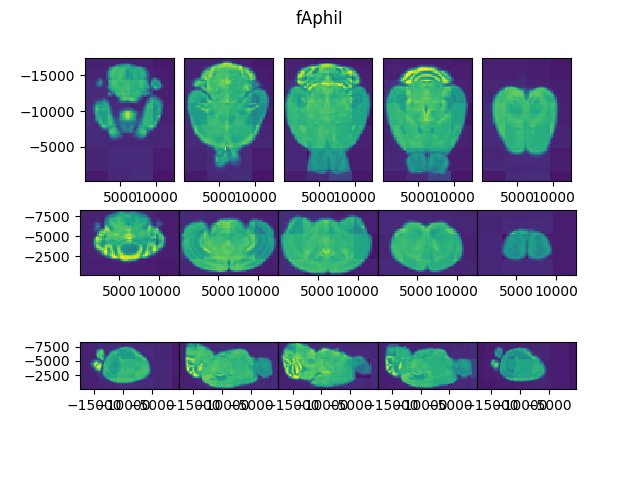

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1057: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figErr = plt.figure()


<IPython.core.display.Javascript object>


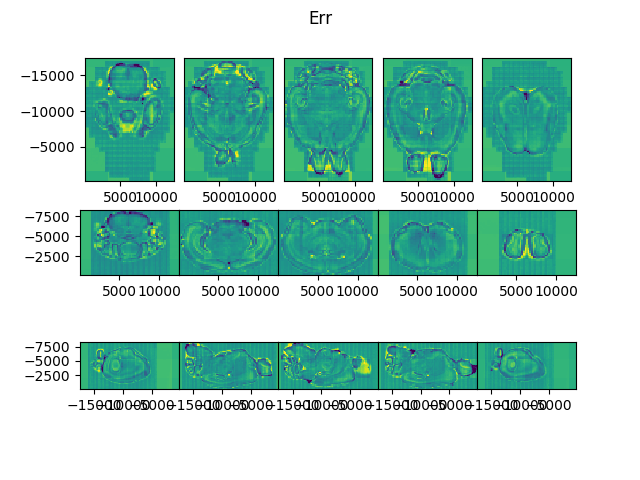

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1058: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figJ = plt.figure()


<IPython.core.display.Javascript object>


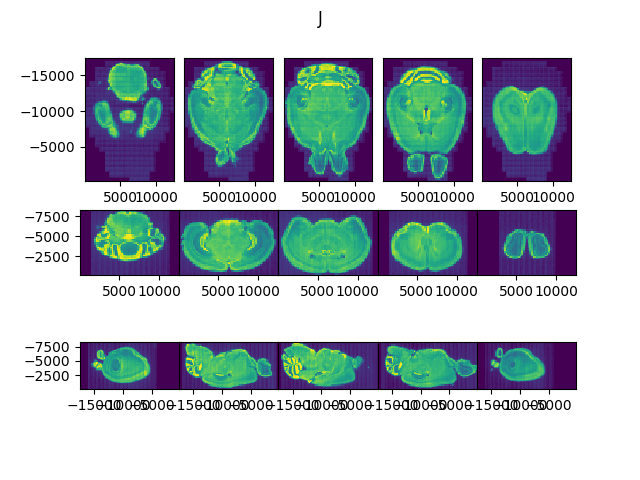

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1059: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figV = plt.figure()


<IPython.core.display.Javascript object>


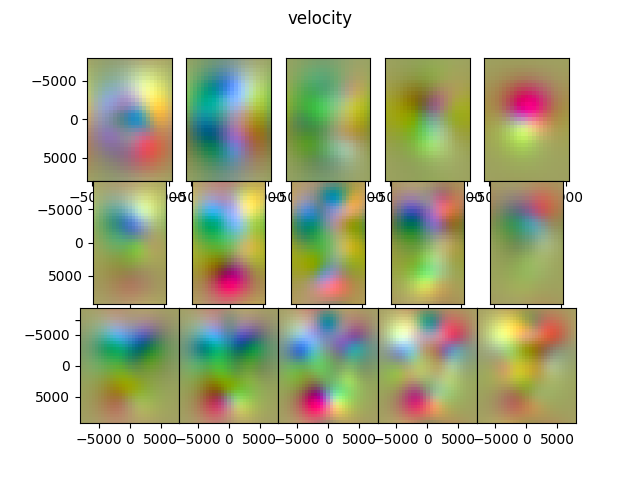

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1060: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figW = plt.figure()


<IPython.core.display.Javascript object>


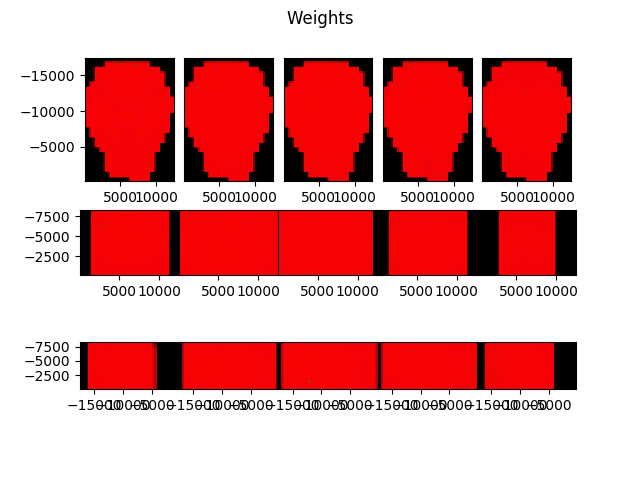

Iteration 80, linear oscilating, reducing eA to 4500.0
Iteration 270, linear oscilating, reducing eA to 4050.0
Iteration 570, linear oscilating, reducing eA to 3645.0
Iteration 590, linear oscilating, reducing eA to 3280.5
Iteration 1400, translation oscilating, reducing eA to 2952.4500000000003
Iteration 1810, translation oscilating, reducing eA to 2657.2050000000004
Iteration 1860, linear oscilating, reducing eA to 2391.4845000000005
Iteration 1900, translation oscilating, reducing eA to 2152.3360500000003


In [21]:
# second run, with deformation
config1 = dict(config0)
config1['A'] = out['A']
config1['eA'] = config0['eA']*0.1
config1['a'] = 1000.0
config1['sigmaR'] = 5e4 # 1e4 gave really good results, but try 2e4, also good, I showed this in my slides
config1['n_iter']= 2000
config1['v_start'] = 0
config1['ev'] = 1e-2
config1['ev'] = 2e-3 # reduce since I decreased sigma
config1['v_res_factor'] = config1['a']/dI[0]/2 # what is the resolution of v, as a multiple of that in I
config1['local_contrast'] = [32,32,32]
config1['local_contrast'] = [16,16,16]
config1['device'] = 'cpu'

#I_ = np.stack((I[2],I[0],I[1],I[0]**2,I[0]*I[1],I[1]**2,))

# note this approach has an issue with background being black
#I_ = np.stack((I[2],I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
#               (I[0]-np.mean(I[0]))**2,
#               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
#               (I[1]-np.mean(I[0]))**2,))
I_ = np.stack((I[0]-np.mean(I[0]),I[1]-np.mean(I[1]),
               (I[0]-np.mean(I[0]))**2,
               (I[0]-np.mean(I[0]))*(I[1]-np.mean(I[1])),
               (I[1]-np.mean(I[0]))**2,))


out1 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config1)

/home/dtward/data/csh_data/emlddmm/emlddmm.py:986: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v,device=device,dtype=dtype)
/home/dtward/data/csh_data/emlddmm/emlddmm.py:1049: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figE,axE = plt.subplots(1,3)


<IPython.core.display.Javascript object>


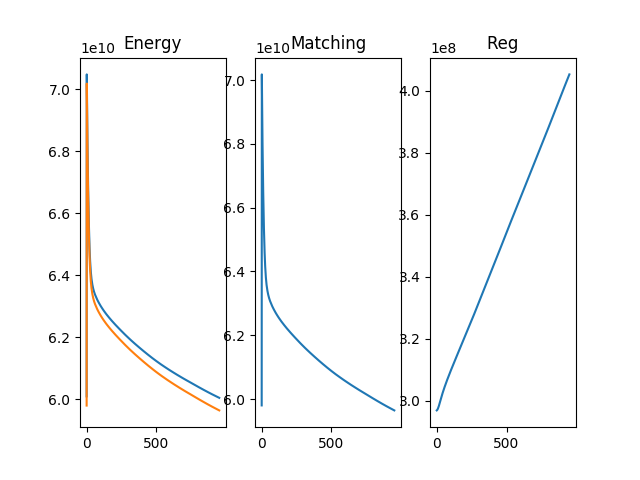

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1050: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figA,axA = plt.subplots(2,2)


<IPython.core.display.Javascript object>


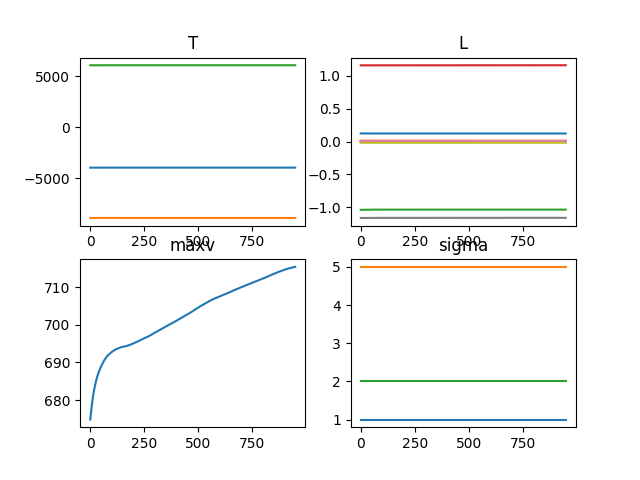

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1055: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figI = plt.figure()


<IPython.core.display.Javascript object>


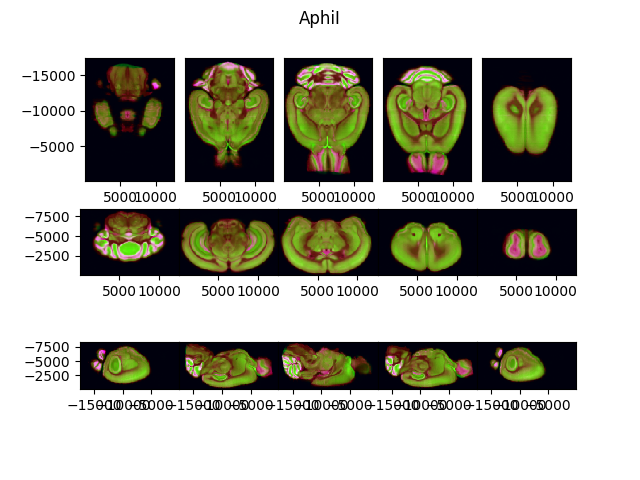

/home/dtward/data/csh_data/emlddmm/emlddmm.py:1056: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figfI = plt.figure()


<IPython.core.display.Javascript object>


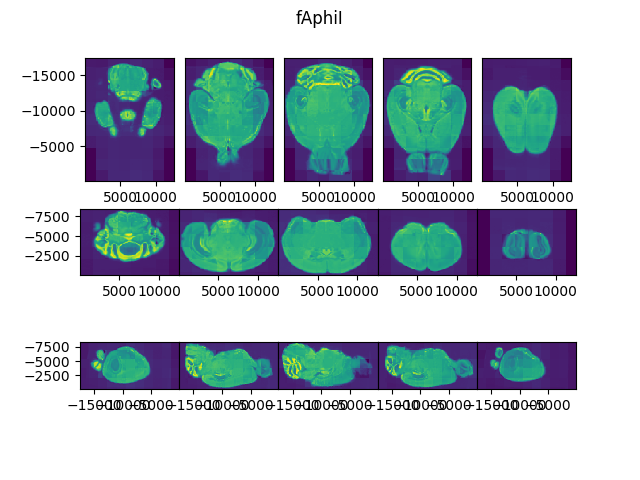

<IPython.core.display.Javascript object>


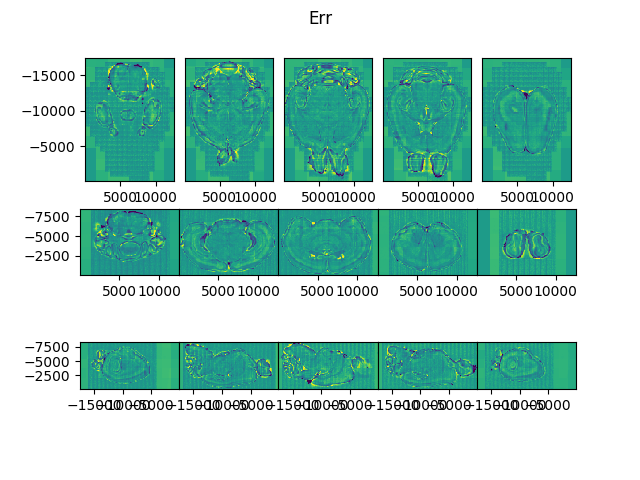

<IPython.core.display.Javascript object>


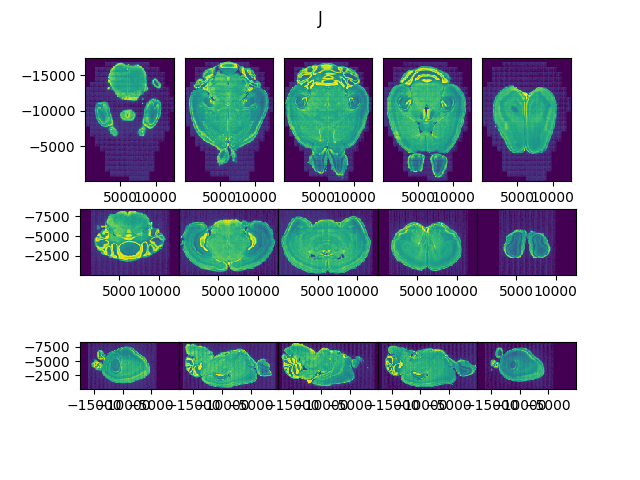

<IPython.core.display.Javascript object>


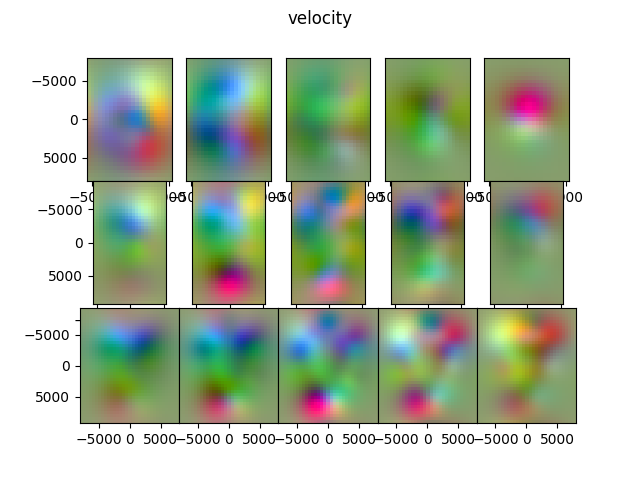

<IPython.core.display.Javascript object>


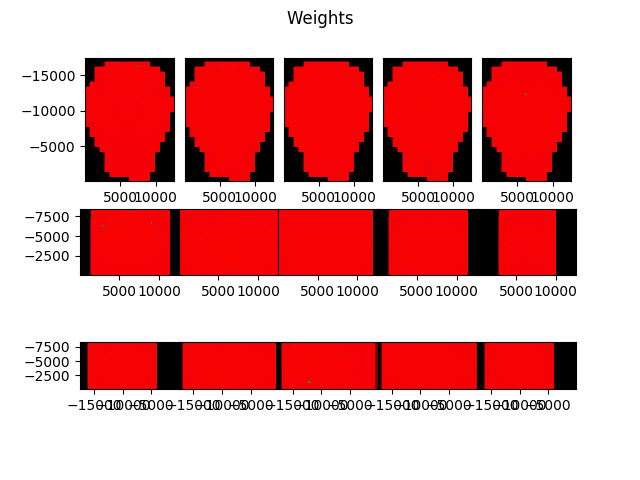

Iteration 310, translation oscilating, reducing eA to 4500.0
Iteration 470, linear oscilating, reducing eA to 4050.0
Iteration 540, linear oscilating, reducing eA to 3645.0
Iteration 570, linear oscilating, reducing eA to 3280.5
Iteration 710, linear oscilating, reducing eA to 2952.4500000000003


In [ ]:
imp.reload(emlddmm)
# on the next run we do les downsampling
config2 = dict(config1)
config2['A'] = out1['A']
config2['n_iter']= 1000
config2['v'] = out1['v']
config2['downI'] = [2,2,2]
config2['downJ'] = [2,2,2]
# there seems to be an issue with the initial velocity
# when I run this twice, I'm reusing it
out2 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=W, **config2)
# the matching energy here is way way lower, why would that be?

In [ ]:
# save the outputs
np.save(output_prefix+savename,np.array([out2],dtype=object))

In [ ]:
out2['figI'].savefig(output_prefix + 'transformed.jpg',**figopts)
out2['figfI'].savefig(output_prefix + 'contrast.jpg',**figopts)
out2['figErr'].savefig(output_prefix + 'err.jpg',**figopts)

In [ ]:
fig = out2['figErr']
axs = fig.get_axes()
for ax in axs:
    ims = ax.get_images()
    for im in ims:
        im.set_cmap('twilight')
        clim = im.get_clim()
        lim = np.max(np.abs(clim))
        im.set_clim(np.array((-1,1))*lim)
fig.canvas.draw()
fig.savefig(output_prefix + 'err.jpg',**figopts)

# Prepare some visualizations

In [29]:
# compute transform for atlas and labels
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='b')
affine = emlddmm.Transform(out2['A'],direction='b')
tform = emlddmm.compose_sequence([affine,deformation],XJ)

In [30]:
# transform the atlas and labels, notice different domains
It = emlddmm.apply_transform_float(xI,I,tform).cpu().numpy()
RGBt = emlddmm.apply_transform_float(xS,RGB,tform).cpu().numpy()
St = emlddmm.apply_transform_int(xS,S,tform,double=True,padding_mode='zeros').cpu().numpy()

/home/dtward/data/csh_data/emlddmm/emlddmm.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


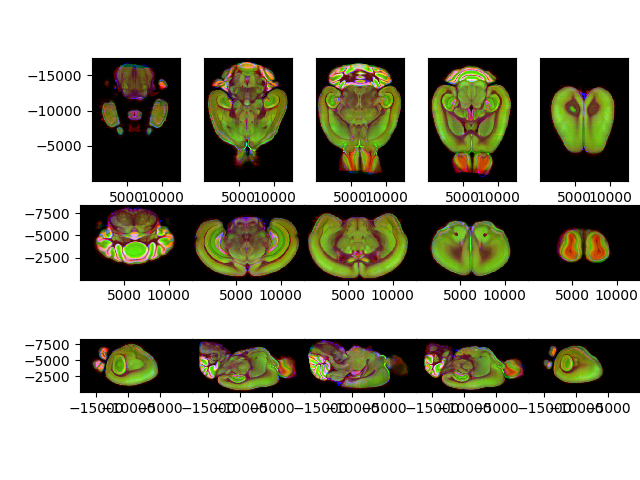

4294967296 4294967296


In [32]:
#fig,ax = emlddmm.draw(np.stack((It[0]*0.5,It[1]*0.5,Jsave[0]*1.5)),xJ,vmin=0,vmax=4)
#fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig,ax = emlddmm.draw(np.stack((It[0]*0.5,It[1]*0.5,J0[0]*1.5)),xJ,)
fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'IJsave.jpg')

<IPython.core.display.Javascript object>


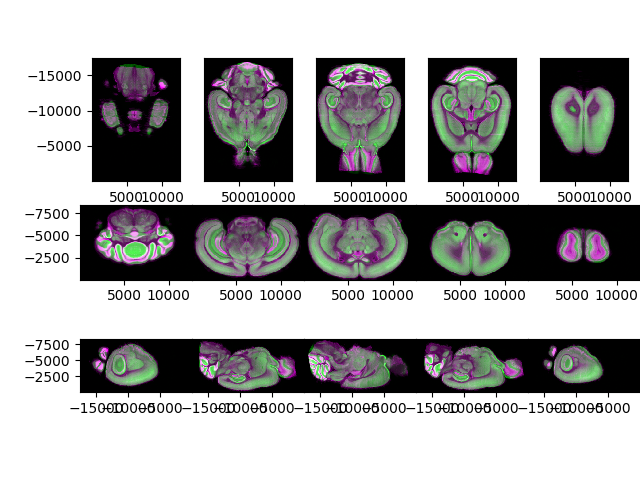

4294967296 4294967296


In [33]:
fig,ax = emlddmm.draw(It,xJ)
fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'Isave.jpg')

<IPython.core.display.Javascript object>


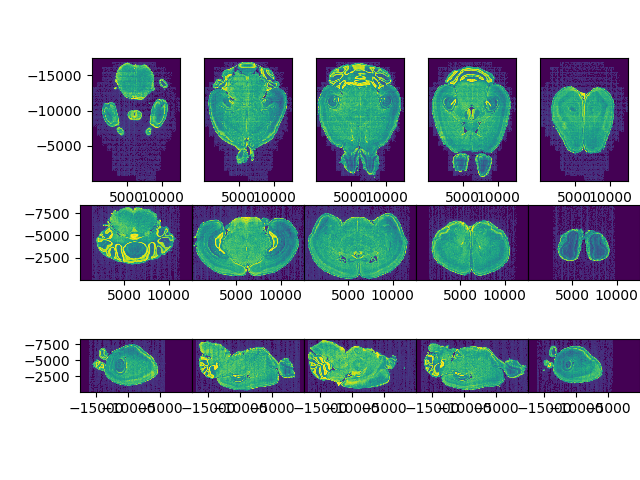

4294967296 4294967296


In [34]:
fig,ax = emlddmm.draw(J,xJ)
plt.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig(output_prefix + 'Jsave.jpg')

In [35]:
# transform the target to atlas
# for visualizatoin, we want to sample at xS so we can view it relative to the
XS = np.stack(np.meshgrid(*xS,indexing='ij'))
imp.reload(emlddmm)
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='f')
affine = emlddmm.Transform(out2['A'],direction='f')
tformi = emlddmm.compose_sequence([deformation,affine,],XS)
#J_ = J0**0.25
J_ = np.copy(J)
Jt = emlddmm.apply_transform_float(xJ,J_,tformi,padding_mode='zeros').cpu().numpy()

<IPython.core.display.Javascript object>


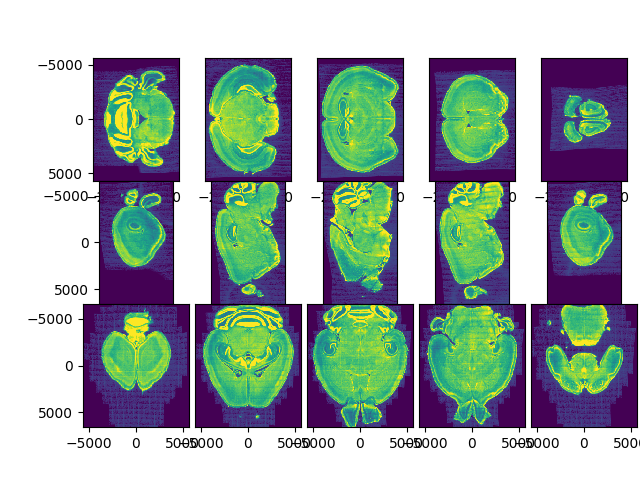

In [36]:
# view the transformed target
fig,ax = emlddmm.draw(Jt,xS,vmin=np.quantile(J_,0.02),vmax=np.quantile(J_,0.98))
fig.subplots_adjust(wspace=0,hspace=0,right=1)

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


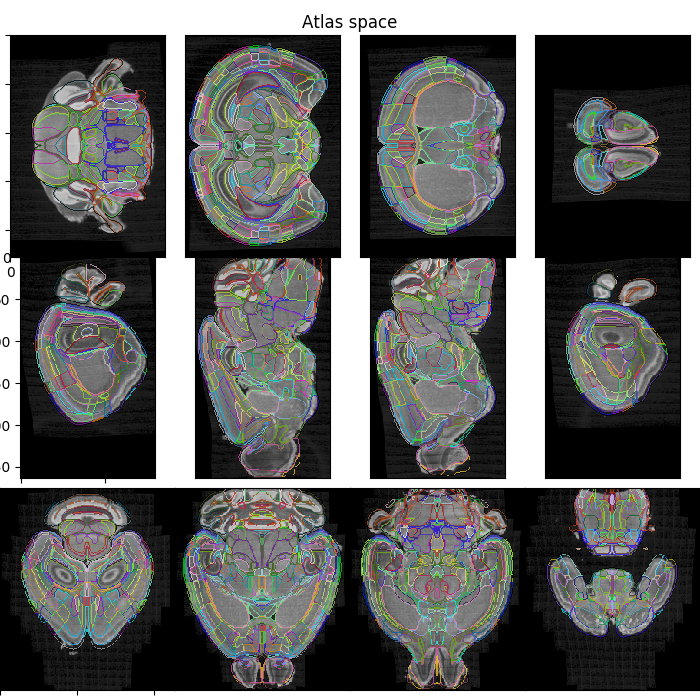

4294967296 4294967296


In [37]:
# view the transformed target with labels
minval = 1.5
maxval = 2.9
minval = 0.0
maxval = 5.0
alpha = 0.3
alpha = 0.75
fig = plt.figure(figsize=(7,7))
n = 4
slices = np.round(np.linspace(0,I.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGB[:,slices[i]].transpose(1,2,0)
    S_ = S[0,slices[i]]
    Jt_ = np.copy(Jt[0,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,I.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGB[:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,I.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGB[:,:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Atlas space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
fig.savefig(output_prefix+'atlas_space.jpg',**figopts)

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


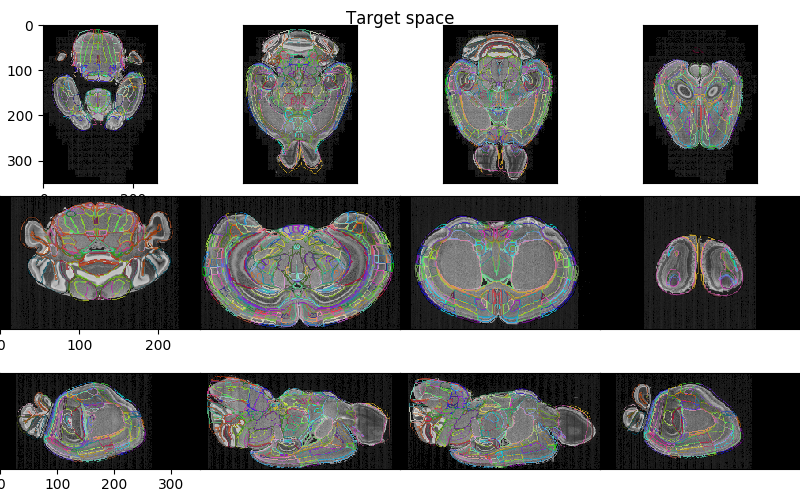

4294967296 4294967296


In [38]:
# view the transformed labels with the target
fig = plt.figure(figsize=(8,5))
slices = np.round(np.linspace(0,J.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGBt[:,slices[i]].transpose(1,2,0)
    S_ = St[0,slices[i]]
    Jt_ = np.copy(J[0,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,J.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGBt[:,:,slices[i]].transpose(1,2,0)
    S_ = St[0,:,slices[i]]
    Jt_ = np.copy(J[0,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,J.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGBt[:,:,:,slices[i]].transpose(1,2,0)
    S_ = St[0,:,:,slices[i]]
    Jt_ = np.copy(J[0,:,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= minval
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= maxval-minval
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Target space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
fig.savefig(output_prefix+'target_space.jpg',**figopts)

# Get bounding boxes for striatum or another structure

In [39]:
# bounding boxes using St
import requests,csv
ontology_name = output_prefix + 'allen_ontology.csv'
r = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,\
rma::criteria,[ontology_id$eq1],\
rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]\
'
if True:# not os.path.exists(ontology_name):
    output = requests.get(r)
    with open(ontology_name,'wt') as f:
        f.write(output.text)

In [40]:
ontology = dict()
with open(ontology_name) as f:
    csvreader = csv.reader(f, delimiter=',', quotechar='"')
    count = 0
    for row in csvreader:
        if count == 0:
            headers = row
            print(headers)
        else:
            if not row[8]:
                parent = -1
            else:
                parent = int(row[8])
            ontology[int(row[0])] = (row[3],row[2],parent)
        count += 1

['id', 'atlas_id', 'name', 'acronym', 'st_level', 'ontology_id', 'hemisphere_id', 'weight', 'parent_structure_id', 'depth', 'graph_id', 'graph_order', 'structure_id_path', 'color_hex_triplet', 'neuro_name_structure_id', 'neuro_name_structure_id_path', 'failed', 'sphinx_id', 'structure_name_facet', 'failed_facet', 'safe_name']


In [41]:
# or we could just loop through
labels = np.unique(St)
bbox = dict()
for l in labels:
    # skip background
    if l == 0:
        continue
    
    Sl = St == l
    bbox2 = xJ[2][np.nonzero(np.sum(Sl,(0,1,2))>0)[0][[0,-1]]]
    bbox1 = xJ[1][np.nonzero(np.sum(Sl,(0,1,3))>0)[0][[0,-1]]]
    bbox0 = xJ[0][np.nonzero(np.sum(Sl,(0,2,3))>0)[0][[0,-1]]]
    bbox[l] = (bbox2[0],bbox2[1],bbox1[0],bbox1[1],bbox0[0],bbox0[1],ontology[l][0],ontology[l][1])
    


In [42]:
import pandas as pd
df = pd.DataFrame(bbox).T
bbox_headings = ('x0','x1','y0','y1','z0','z1','short name','long name')
df.columns=bbox_headings
df.index.name = 'id'

In [43]:
df

x0       x1       y0       y1      z0      z1 short name  \
id                                                                        
1          4674.5   7474.5 -10282.5  -9732.5 -6975.5 -6375.5        TMv   
2          2224.5  10074.5  -8082.5  -6382.5 -3825.5 -2325.5    SSp-m6b   
6          2374.5   9924.5 -10282.5  -7382.5 -6225.5 -3075.5        int   
7          3574.5   8724.5 -13432.5 -12182.5 -7075.5 -5375.5        PSV   
9          3474.5   8974.5 -10082.5  -8932.5 -1525.5  -875.5   SSp-tr6a   
...           ...      ...      ...      ...     ...     ...        ...   
607344850  5824.5   6474.5 -11582.5 -10882.5 -6025.5 -5675.5        IPI   
607344854  5924.5   6374.5 -11732.5 -11082.5 -5525.5 -5275.5       IPDM   
607344858  5774.5   6524.5 -11582.5 -10832.5 -5725.5 -5425.5       IPDL   
607344862  5724.5   6524.5 -11182.5 -10782.5 -5675.5 -5325.5       IPRL   
614454277  5674.5   6674.5 -12382.5 -11882.5 -4075.5 -3725.5        Su3   

                                             long name  
id                                                      
1               Tuberomammillary nucleus, ventral part  
2          Primary somatosensory area, mouth, layer 6b  
6                                     internal capsule  
7          Principal sensory nucleus of the trigeminal  
9          Primary somatosensory area, trunk, layer 6a  
...                                                ...  
607344850        Interpeduncular nucleus, intermediate  
607344854         Interpeduncular nucleus, dorsomedial  
607344858        Interpeduncular nucleus, dorsolateral  
607344862       Interpeduncular nucleus, rostrolateral  
614454277          Supraoculomotor periaqueductal gray  

[670 rows x 8 columns]

In [44]:
df.to_csv(output_prefix + 'bboxes.csv')

In [45]:
# TODO, separate left from right in bounding box

In [ ]:
# TODO, use a surface instead of bounding box. use marching cubes. figure out file format.

In [ ]:
# see link on slack vrml (wireframe objects9-)